In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

# Energie electrique americaine

In [2]:
df = pd.read_csv(r'C:\Users\nico_\Desktop\series_temporelles\AEP_hourly.csv')

In [3]:
df["Datetime"] = pd.to_datetime(df["Datetime"])

In [4]:
df = df.sort_values(by="Datetime")

In [5]:
df.head()

,Datetime,AEP_MW
2183,2004-10-01 01:00:00,12379.0
2184,2004-10-01 02:00:00,11935.0
2185,2004-10-01 03:00:00,11692.0
2186,2004-10-01 04:00:00,11597.0
2187,2004-10-01 05:00:00,11681.0


In [6]:
df = df.set_index('Datetime')

In [7]:
df.head()

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


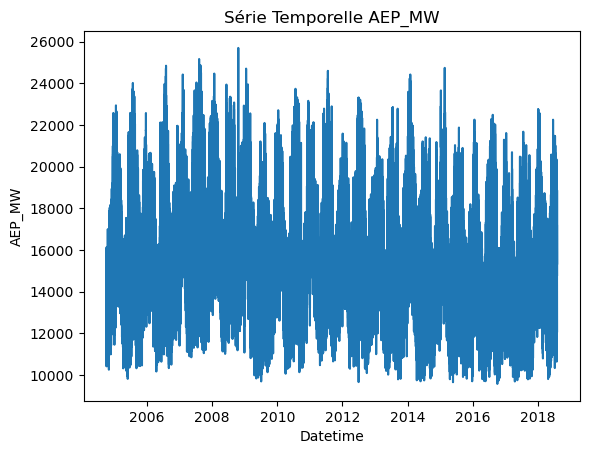

In [8]:
plt.plot(df.index, df['AEP_MW'])
plt.xlabel('Datetime')
plt.ylabel('AEP_MW')
plt.title('Série Temporelle AEP_MW')
plt.show()

# Données par mois pour réduire le temps d'entrainement et de prédiction

In [9]:
df2 = df.resample('M').mean()

In [10]:
df2.head()

,AEP_MW
Datetime,
2004-10-31,13947.537736
2004-11-30,14830.440278
2004-12-31,16737.720430
2005-01-31,17117.088710
2005-02-28,16496.644345


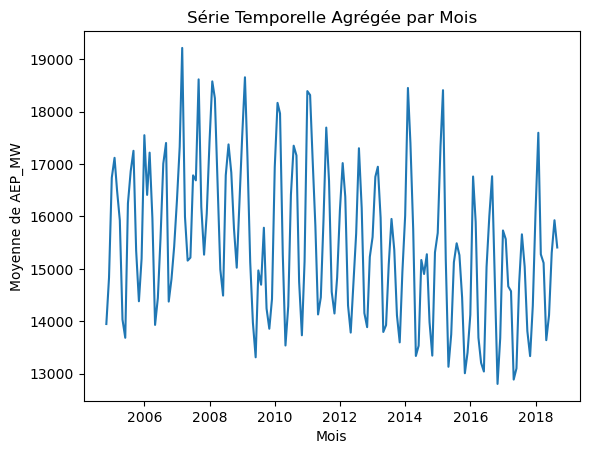

In [11]:
plt.plot(df2.index, df2['AEP_MW'])
plt.xlabel('Mois')
plt.ylabel('Moyenne de AEP_MW')
plt.title('Série Temporelle Agrégée par Mois')
plt.show()

In [12]:
len(df2["AEP_MW"])

167

# Split mean

In [13]:
split_time = (len(df2["AEP_MW"]) * 70)/100
split_time

116.9

In [14]:
split_time = 116

In [15]:
# Train
time_train = df2.index[:split_time]
x_train = df2["AEP_MW"][:split_time]

# Validation
time_val = df2.index[split_time:]
x_val = df2["AEP_MW"][split_time:]

# Standardisation des données

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train.values.reshape(-1, 1))

x_val_scaled = scaler.transform(x_val.values.reshape(-1, 1))

# Préparation features et labels Mean

In [17]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 100

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size +1, shift = 1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size +1))
    dataset = dataset.map(lambda window: (window[:-1],window[-1]))
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

# Utilisation de la fonction avec X_train mean

In [19]:
dataset = windowed_dataset(x_train_scaled, window_size, batch_size, shuffle_buffer_size)

In [20]:
for x, y in dataset:
    print(x.numpy(), y.numpy())

[[[-0.67176187]
  [ 0.22043767]
  [ 0.84633023]
  [ 0.39788618]
  [-1.04649877]
  [-1.40706993]
  [-0.74681394]
  [-0.09032347]
  [ 1.04381835]
  [ 0.25003718]
  [-1.14825575]
  [-1.33472159]
  [-0.40038821]
  [-0.13699229]
  [ 0.66419704]
  [ 0.79774074]
  [ 0.1191349 ]
  [-1.39899567]
  [-1.30808587]
  [-0.50397206]]

 [[-1.35575674]
  [-0.95957607]
  [ 0.79462548]
  [ 1.6470266 ]
  [ 1.50627725]
  [-0.3738181 ]
  [-1.57871999]
  [-1.05635649]
  [ 0.42496075]
  [ 1.07747703]
  [ 0.94793688]
  [-0.73158718]
  [-1.44299233]
  [-0.46009716]
  [ 1.80329909]
  [ 1.75127659]
  [ 0.90380912]
  [ 0.01207143]
  [-1.16580438]
  [-0.93774105]]

 [[ 1.98727997]
  [ 0.92868009]
  [-0.47298124]
  [-1.27422264]
  [-1.73566853]
  [-0.58048249]
  [-0.77041746]
  [-0.01307698]
  [-1.08588763]
  [-1.35575674]
  [-0.95957607]
  [ 0.79462548]
  [ 1.6470266 ]
  [ 1.50627725]
  [-0.3738181 ]
  [-1.57871999]
  [-1.05635649]
  [ 0.42496075]
  [ 1.07747703]
  [ 0.94793688]]

 [[-0.99066356]
  [-0.42353827]
  

# Model mean

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1050      
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1571 (6.14 KB)
Trainable params: 1571 (6.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training mean

In [24]:
history = model.fit(dataset, epochs=1000)

Epoch 1/1000
3/3 [==============================] - 1s 33ms/step - loss: 0.8784
Epoch 2/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.8384
Epoch 3/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.7736
Epoch 4/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.6981
Epoch 5/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.6231
Epoch 6/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.5588
Epoch 7/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.5019
Epoch 8/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.4575
Epoch 9/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.4196
Epoch 10/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.3933
Epoch 11/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.3696
Epoch 12/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.3525
Epoch 13/1000
3/3 [=============================

Text(0.5, 1.0, 'Training loss')

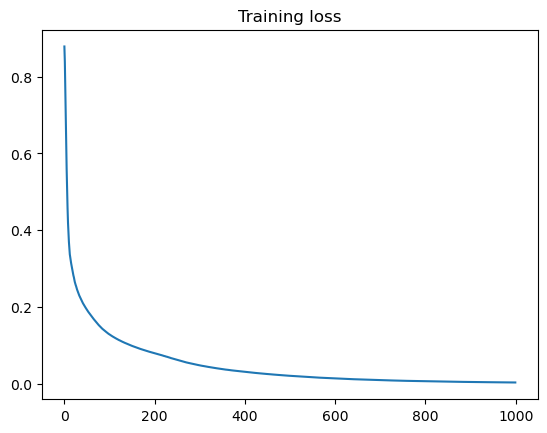

In [25]:
loss     = history.history['loss']
epochs   = range(len(loss))
plt.plot  ( epochs,     loss )
plt.title ('Training loss')

In [26]:
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [27]:
df2["AEP_MW_scaled"] = scaler.fit_transform(df2['AEP_MW'].values.reshape(-1, 1))

In [28]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

2/2 [==============================] - 0s 17ms/step


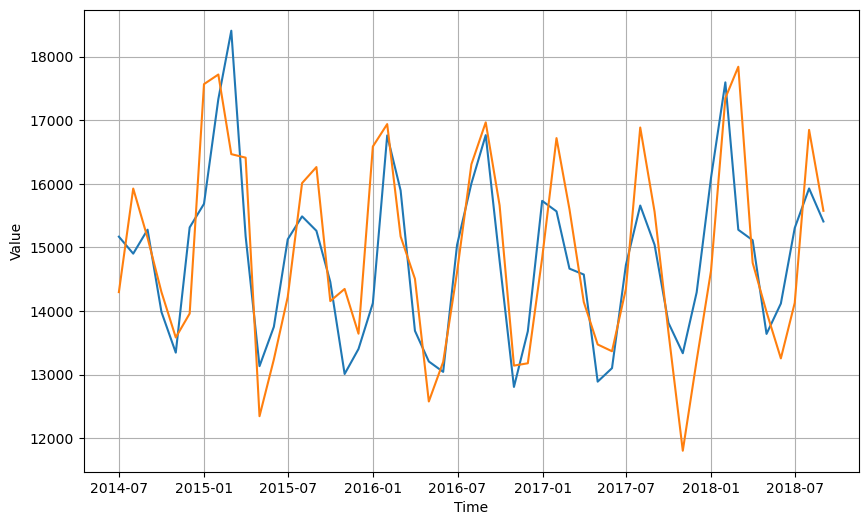

In [29]:
# Reduce the original series
forecast_series = df2['AEP_MW_scaled'][split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()
results = results.reshape(-1, 1)
results_original = scaler.inverse_transform(results)

# Plot the results
plot_series(time_val, (x_val, results_original))

In [30]:
mse = tf.keras.metrics.mean_squared_error(x_val, results_original).numpy()
mae = tf.keras.metrics.mean_absolute_error(x_val, results_original).numpy()

In [31]:
print("Mean Squared Error (MSE) Mean:", np.mean(mse))
print("Mean Absolute Error (MAE) Mean:", np.mean(mae))

Mean Squared Error (MSE) Mean: 3948255.0
Mean Absolute Error (MAE) Mean: 1616.2218


In [32]:
print("min:", x_val.min())
print("max:", x_val.max())

min: 12805.127688172042
max: 18407.07738095238


# Modèle avec plus de couches

In [33]:
dataset = windowed_dataset(x_train_scaled, window_size, batch_size, shuffle_buffer_size)

In [34]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [35]:
model2.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9))

In [36]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50)                1050      
                                                                 
 dense_4 (Dense)             (None, 30)                1530      
                                                                 
 dense_5 (Dense)             (None, 20)                620       
                                                                 
 dense_6 (Dense)             (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3421 (13.36 KB)
Trainable params: 3421 (13.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
history2 = model2.fit(dataset, epochs=1000)

Epoch 1/1000
3/3 [==============================] - 1s 32ms/step - loss: 1.1505
Epoch 2/1000
3/3 [==============================] - 0s 4ms/step - loss: 1.1276
Epoch 3/1000
3/3 [==============================] - 0s 3ms/step - loss: 1.0915
Epoch 4/1000
3/3 [==============================] - 0s 3ms/step - loss: 1.0487
Epoch 5/1000
3/3 [==============================] - 0s 3ms/step - loss: 1.0037
Epoch 6/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.9598
Epoch 7/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.9124
Epoch 8/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.8686
Epoch 9/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.8173
Epoch 10/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.7734
Epoch 11/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.7266
Epoch 12/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.6865
Epoch 13/1000
3/3 [=============================

Text(0.5, 1.0, 'Training loss')

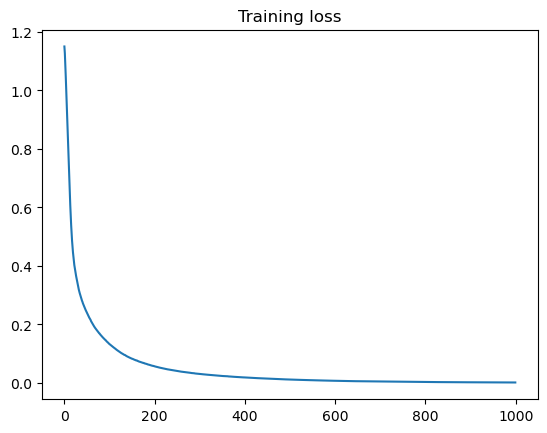

In [38]:
loss     = history2.history['loss']
epochs   = range(len(loss))
plt.plot  ( epochs,     loss )
plt.title ('Training loss')

In [39]:
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [40]:
df2["AEP_MW_scaled"] = scaler.fit_transform(df2['AEP_MW'].values.reshape(-1, 1))

2/2 [==============================] - 0s 15ms/step


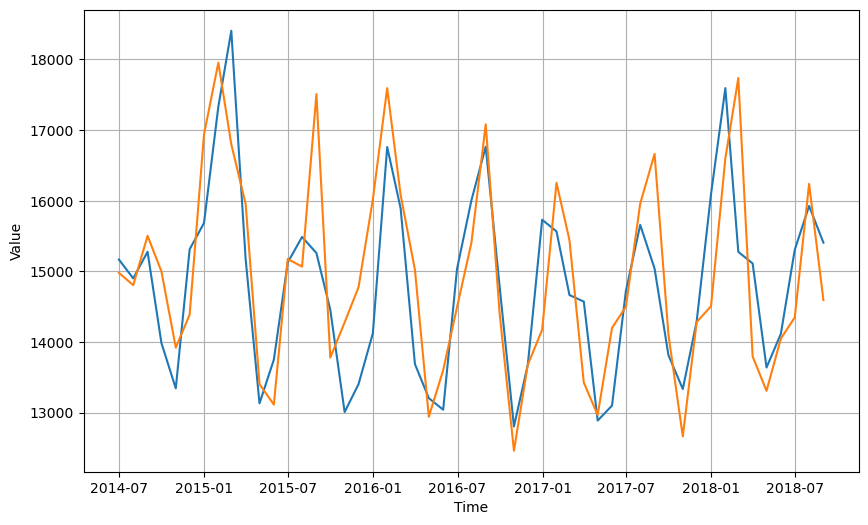

In [41]:
# Reduce the original series
forecast_series = df2['AEP_MW_scaled'][split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model2, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()
results = results.reshape(-1, 1)
results_original = scaler.inverse_transform(results)

# Plot the results
plot_series(time_val, (x_val, results_original))

In [42]:
mse = tf.keras.metrics.mean_squared_error(x_val, results_original).numpy()
mae = tf.keras.metrics.mean_absolute_error(x_val, results_original).numpy()

In [43]:
print("Mean Squared Error (MSE) Mean:", np.mean(mse))
print("Mean Absolute Error (MAE) Mean:", np.mean(mae))

Mean Squared Error (MSE) Mean: 3576764.8
Mean Absolute Error (MAE) Mean: 1522.2235
